# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [ ]:
# data_preper.simulate_negative_control(ratio_samplingFrom=0.2, negative_samples_proportion=0.2, ratio_mask=0.7)
# data_preper.normalize()
# data_preper

In [6]:
# Step 2. Train a local classifer
clf = pytacs.QProximityClassifier(threshold_confidence=0.15, n_PCs=2)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [15]:
clf.set_threshold_confidence(0.4)

In [16]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=200,
                            threshold_adjacent=1.2,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.QProximityClassifier object at 0x7f883a5a20f0>
    + threshold_confidence: 0.4
    + has_negative_control: False
- max_spots_per_cell: 200
- scale_rbf: 1.0
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [17]:
sph.run_segmentation(
    coverage_to_stop=0.1,
    max_iter=20,
    verbose=True,
    warnings=False,
    print_summary=True,
)

Iteration 1:
Querying spot 419 ...
Spot 419 | confidence: 4.072e-01 | confident total: 1 | class: 1
Classes total: {1: 1}
Coverage: 2.81%
Iteration 6:
Querying spot 1318 ...
Spot 1318 | confidence: 4.026e-01 | confident total: 2 | class: 1
Classes total: {1: 2}
Coverage: 5.54%
Done.
--- Summary ---
Queried 20 spots (with replacement), of which 4 made up confident single cells.
Classes total (this round): {1: 4}
Coverage: 10.85%
--- --- --- --- ---



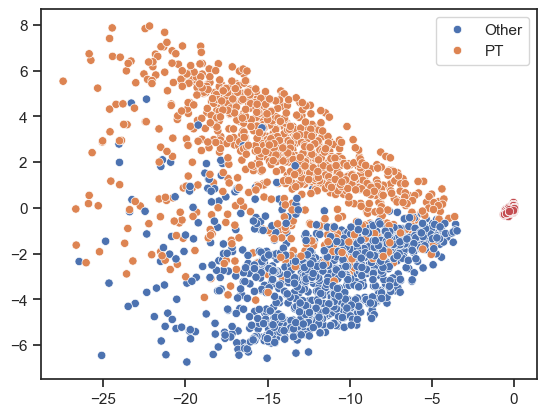

In [18]:
import numpy as np

import pytacs.utils
xx = np.log1p(data_preper.sn_adata.X) @ clf._PC_loadings.T
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x=xx[:,0],y=xx[:,1],hue=data_preper.sn_adata.obs['cell_type'])
X_sp_submatrix = pytacs.utils.subCountMatrix_genes2InGenes1(
    X=data_preper.sp_adata.X.toarray(),
    genes1=data_preper.sn_adata.var.index,
    genes2=data_preper.sp_adata.var.index
)
xx_sp = np.log1p(X_sp_submatrix) @ clf._PC_loadings.T
sns.scatterplot(x=xx_sp[:,0],y=xx_sp[:,1],c='r')
plt.show()

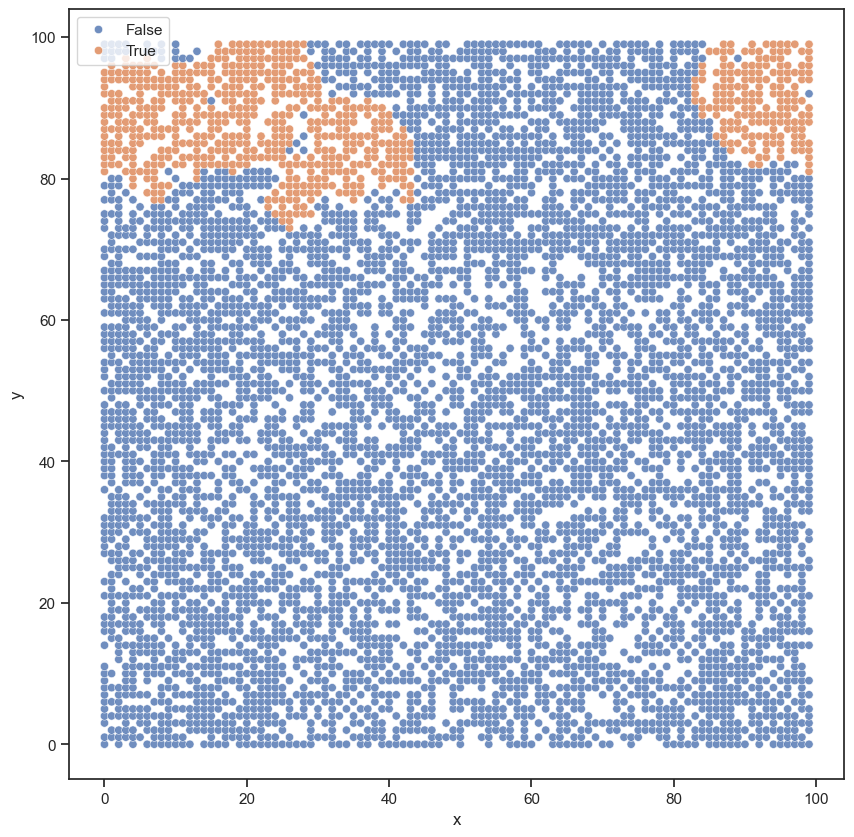

In [19]:
# See the integrated spots
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sns.scatterplot(
    x=data_preper.sp_adata.obs['x'],
    y=data_preper.sp_adata.obs['y'],
    hue=sph.mask_newIds>-1,
    alpha=0.8,
)
plt.show()
# I used to use a 8-neighbor strategy so the shape might look quite dispersed;
# you can lower the threshold_adjacent to 1.2 or so to apply a 4-neighbor
# strategy for the shape to be denser.

In [20]:
# Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)

In [21]:
print(sp_singleCell)

AnnData object with n_obs × n_vars = 4 × 5227
    obs: 'x', 'y', 'old_index', 'confidence'


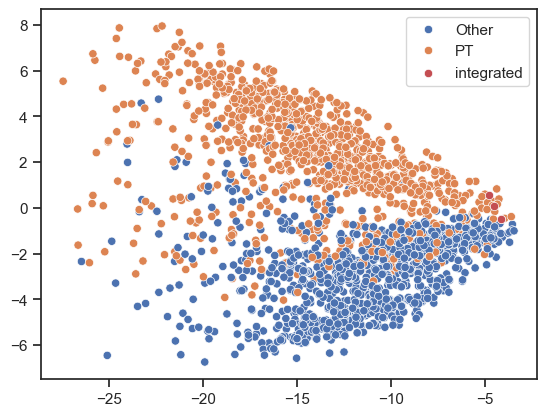

In [23]:
import numpy as np

import pytacs.utils
xx = np.log1p(data_preper.sn_adata.X) @ clf._PC_loadings.T
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x=xx[:,0],y=xx[:,1],hue=data_preper.sn_adata.obs['cell_type'])
X_sp_submatrix = pytacs.utils.subCountMatrix_genes2InGenes1(
    X=sp_singleCell.X.toarray(),
    genes1=data_preper.sn_adata.var.index,
    genes2=sp_singleCell.var.index
)
xx_sp = np.log1p(X_sp_submatrix) @ clf._PC_loadings.T
sns.scatterplot(x=xx_sp[:,0],y=xx_sp[:,1],c='r', label='integrated')
plt.show()